## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gymnasium as gym
from diffuser.utils.config import Config, get_params, get_device_settings
from diffuser.utils.training import Trainer
from diffuser.utils.arrays import report_parameters, batchify

import os
import collections
import numpy as np
import pdb
from minari import DataCollector, StepDataCallback
import torch
import sys
import matplotlib.pyplot as plt
import h5py
from datetime import datetime
import wandb

c:\Users\Beste Aydemir\AppData\Local\pypoetry\Cache\virtualenvs\adlr-uQXv-DS1-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parse Arguments and Paramters

In [4]:
# Get settings from the config file

parser = get_params()

args = parser.parse_known_args(sys.argv[1:])[0]

# Set Seeds
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Get device settings
#device = get_device_settings(args)
device = "cpu"

In [5]:
dataset_config = Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env=args.env_name,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
)

render_config = Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env=args.env_name,
)

model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=args.observation_dim + args.action_dim,
    cond_dim=args.observation_dim,
    dim_mults=args.dim_mults,
    device=device,
)
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=args.horizon,
    observation_dim=args.observation_dim,
    action_dim=args.action_dim,
    n_timesteps=args.n_timesteps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    # loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=device,
)

trainer_config = Config(
    Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=args.train_batch_size,
    name=args.env_name,
    train_lr=args.train_lr,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=args.label_freq,
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
    n_samples=args.n_samples,
    device=device,
)

_class:datasets.sequence.GoalDataset
[ utils/config ] Imported diffuser.datasets.sequence:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: PointMaze_Medium-v3
    horizon: 256
    max_path_length: 1000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: saved/dataset_config.pkl

_class:utils.rendering.Maze2dRenderer
[ utils/config ] Imported diffuser.utils.rendering:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: PointMaze_Medium-v3

[ utils/config ] Saved config to: saved/render_config.pkl

_class:models.temporal.TemporalUnet
[ utils/config ] Imported diffuser.models.temporal:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 4
    dim_mults: (1, 4, 8)
    horizon: 256
    transition_dim: 6

[ utils/config ] Saved config to: saved/model_config.pkl

_class:mod

In [6]:
# Load objects
dataset = dataset_config()
renderer = render_config()
model = model_config()
diffuser = diffusion_config(model)
trainer = trainer_config(diffuser, dataset, renderer,device)

Name of the enviornment: PointMaze_Medium-v3
Name of the enviornment: PointMaze_Medium-v3
Dataset_name:pointmaze-medium-v2
C:\Users\Beste Aydemir\.minari\datasets\kitchen-complete-v1\data
kitchen-complete-v1
C:\Users\Beste Aydemir\.minari\datasets\pointmaze-medium-v2\data
pointmaze-medium-v2
dataset exists!
[ datasets/buffer ] Finalized replay buffer | 4752 episodes
[ datasets/buffer ] Fields:
    achieved_goal: (4752, 1000, 2)
    desired_goal: (4752, 1000, 2)
    observations: (4752, 1000, 4)
    observation: (4752, 1000, 4)
    next_observations: (4752, 1000, 4)
    actions: (4752, 1000, 2)
    terminals: (4752, 1000, 1)
    timeouts: (4752, 1000, 1)
[ datasets/buffer ] Fields:
    achieved_goal: (4752, 1000, 2)
    desired_goal: (4752, 1000, 2)
    observations: (4752, 1000, 4)
    observation: (4752, 1000, 4)
    next_observations: (4752, 1000, 4)
    actions: (4752, 1000, 2)
    terminals: (4752, 1000, 1)
    timeouts: (4752, 1000, 1)
    normed_observations: (4752, 1000, 4)
    

In [7]:
model_path = "saved/10_ep/state_100000.pt"
trainer.load(directory=model_path, epoch=100000)

## 10 Samples from the Same Point

c:\Users\Beste Aydemir\diffuser-third-test\diffuser\utils\training.py:445: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.tensor(end_tensor).reshape(1, -1), zeros), dim=0
c:\Users\Beste Aydemir\diffuser-third-test\diffuser\utils\training.py:450: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(start_tensor).reshape(


The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 10


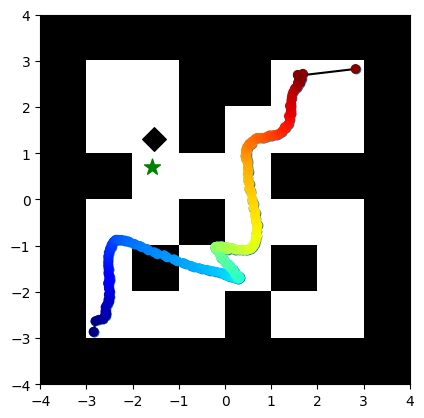

Saved 1 samples to: saved/sample-100000-0.png
Collision observations:


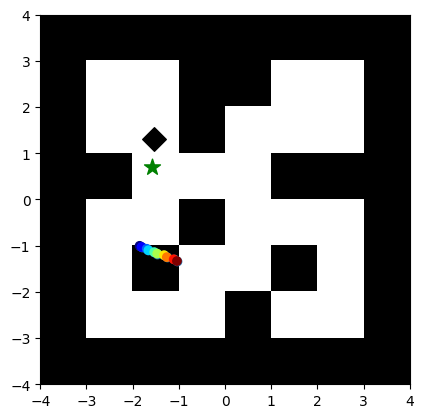

Saved 1 samples to: saved/sample-100000-0.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 0


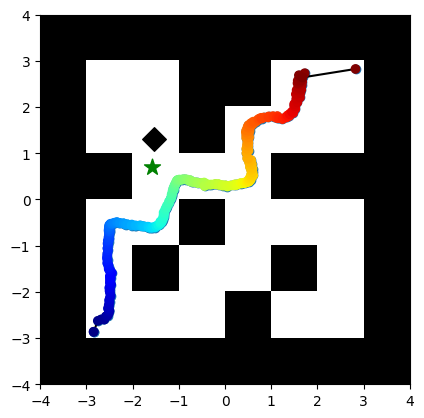

Saved 1 samples to: saved/sample-100000-1.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 19


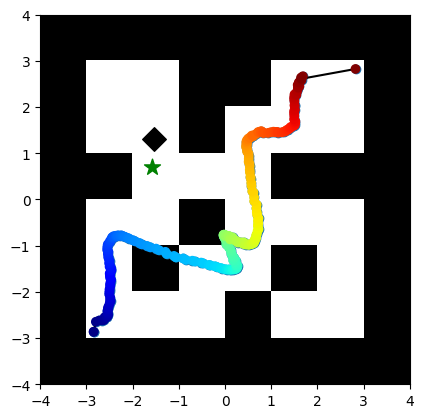

Saved 1 samples to: saved/sample-100000-2.png
Collision observations:


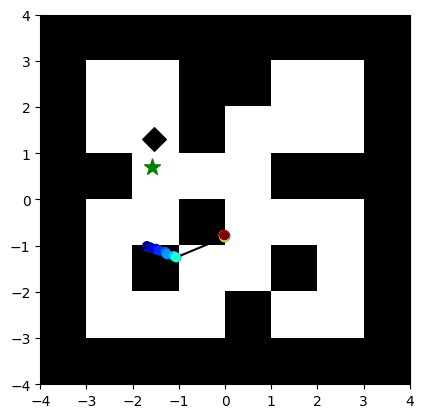

Saved 1 samples to: saved/sample-100000-2.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 0


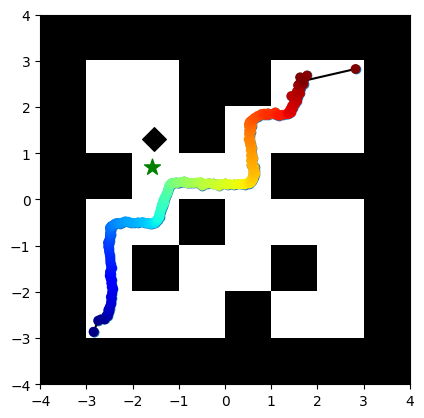

Saved 1 samples to: saved/sample-100000-3.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 17


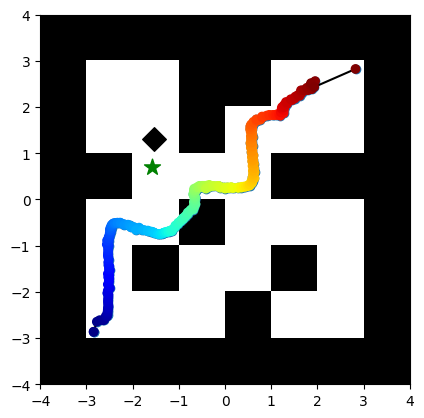

Saved 1 samples to: saved/sample-100000-4.png
Collision observations:


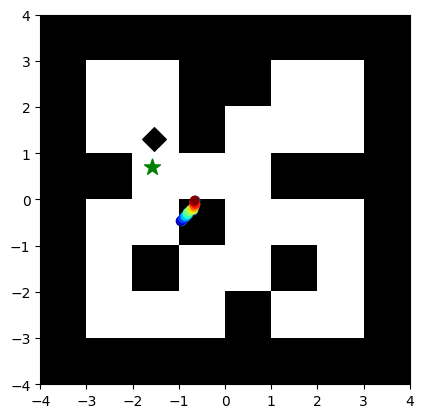

Saved 1 samples to: saved/sample-100000-4.png


KeyboardInterrupt: 

In [8]:
env = gym.make(args.env_name)
env.reset()
trainer.render_samples_starting(env, get_cond_from_env = False, 
                                start_tensor= torch.tensor([-2.90, -2.90]), 
                                end_tensor = torch.tensor([2.90, 2.90]),
                                batch_size = 10)

## Samples from in the same square

In [9]:

# Function to generate random start and end tensors
def generate_random_tensors(batch_size):
    start_tensor = torch.zeros((batch_size, 2))
    end_tensor = torch.zeros((batch_size, 2))
    
    start_tensor[:, 0] = -3 + 0*torch.rand(batch_size)  # Sample between 2 and 3 for the first value
    start_tensor[:, 1] = -3 + 0*torch.rand(batch_size)  # Sample between -3 and -2 for the second value
    
    end_tensor[:, 0] = 2 + 0*torch.rand(batch_size)  # Sample between -3 and -2 for the first value
    end_tensor[:, 1] = 2 + 0*torch.rand(batch_size)  # Sample between 2 and 3 for the second value
    
    return start_tensor, end_tensor



# for _ in range(5):
#     start_tensor, end_tensor = generate_random_tensors(1)
#     print(start_tensor, end_tensor)

#     trainer.render_samples_starting(
#         env,
#         get_cond_from_env=False,
#         start_tensor=start_tensor,
#         end_tensor=end_tensor,
#         batch_size=1
#     )

## Different Generations on the same Image

Observations list: 1
Observations list: 2
Observations list: 3
Observations list: 4
[array([[[-2.8435726 , -2.0222268 ,  0.        ,  0.        ],
        [-2.8435726 , -2.0222268 ,  0.        ,  0.        ],
        [-2.8222184 , -2.1593468 ,  0.31556368,  0.7512584 ],
        ...,
        [ 2.4332771 ,  2.4948745 , -0.63877535,  0.56576204],
        [ 2.521564  ,  2.4760466 , -0.4331479 ,  0.25583363],
        [ 2.620933  ,  2.4809008 ,  0.        ,  0.        ]]],
      dtype=float32), array([[[-2.2464237 , -2.5548954 ,  0.        ,  0.        ],
        [-2.2464237 , -2.5548954 ,  0.        ,  0.        ],
        [-2.324294  , -2.5491672 ,  0.5637827 ,  0.15118599],
        ...,
        [ 1.9716983 ,  2.5174494 , -0.5310793 ,  0.7187748 ],
        [ 1.9726195 ,  2.5038238 , -0.30981255,  0.4067006 ],
        [ 2.1190915 ,  2.5572972 ,  0.        ,  0.        ]]],
      dtype=float32), array([[[-2.6694045 , -2.5653186 ,  0.        ,  0.        ],
        [-2.6694045 , -2.5653186 , 

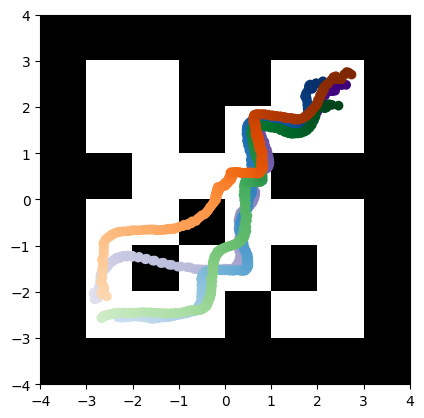

In [29]:

start_tensors = []
end_tensors = []
for _ in range(4):
    start_tensor, end_tensor = generate_random_tensors(1)
    start_tensors.append(start_tensor)
    end_tensors.append(end_tensor)


trainer.render_samples_list(
    env,
    1,
    start_tensors,
    end_tensors
)

c:\Users\Beste Aydemir\diffuser-third-test\diffuser\utils\training.py:542: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.tensor(end_tensors[i]).reshape(1, -1), zeros), dim=0
c:\Users\Beste Aydemir\diffuser-third-test\diffuser\utils\training.py:547: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(start_tensors[i]).reshape(


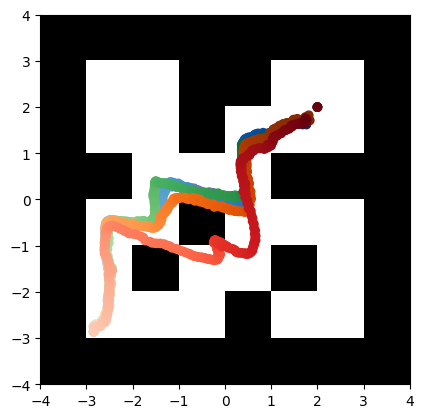

In [10]:

start_tensors = []
end_tensors = []
for _ in range(5):
    start_tensor, end_tensor = generate_random_tensors(1)
    start_tensors.append(start_tensor)
    end_tensors.append(end_tensor)


trainer.render_samples_list(
    env,
    1,
    start_tensors,
    end_tensors
)

The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 20


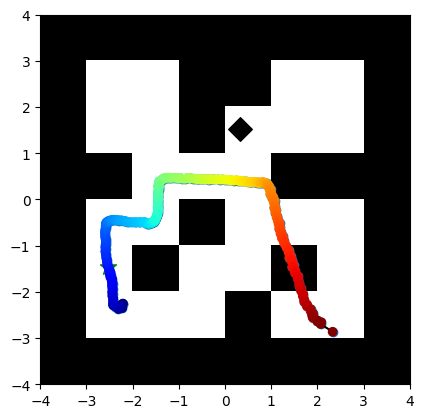

Saved 1 samples to: saved/sample-900000-0.png
Collision observations:


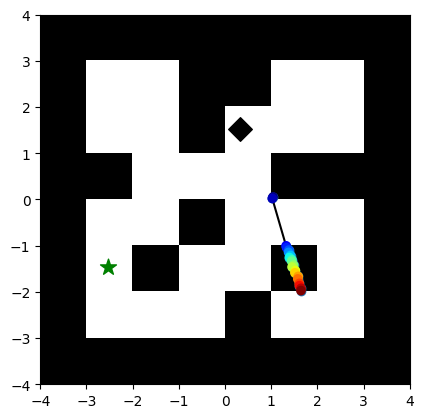

Saved 1 samples to: saved/sample-900000-0.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 26


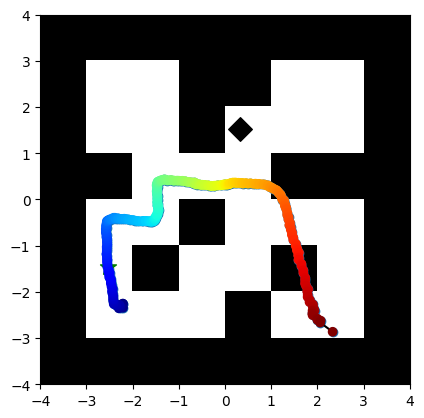

Saved 1 samples to: saved/sample-900000-1.png
Collision observations:


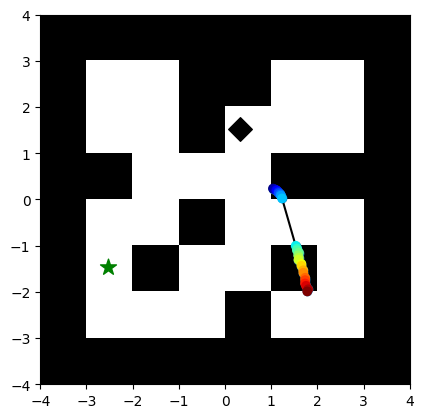

Saved 1 samples to: saved/sample-900000-1.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 17


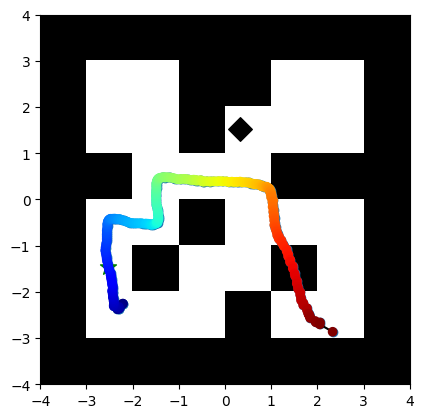

Saved 1 samples to: saved/sample-900000-2.png
Collision observations:


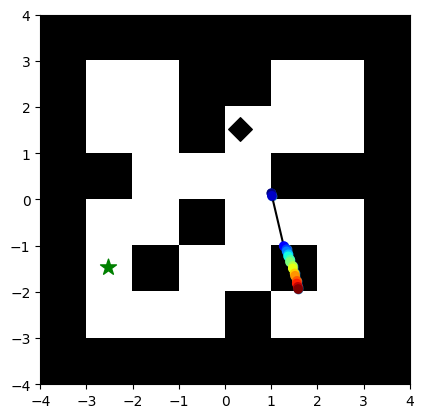

Saved 1 samples to: saved/sample-900000-2.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 17


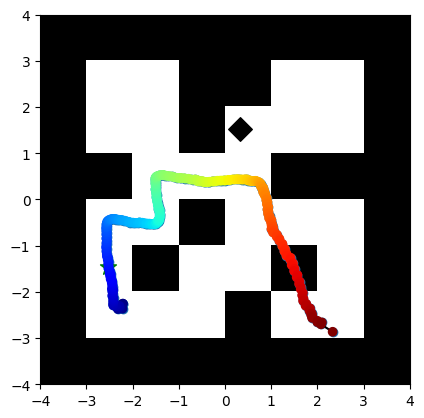

Saved 1 samples to: saved/sample-900000-3.png
Collision observations:


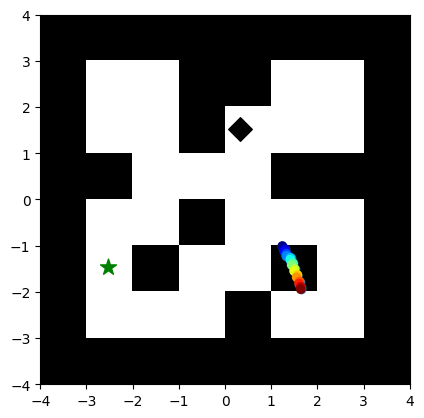

Saved 1 samples to: saved/sample-900000-3.png
The trajectory generated by the diffusion model:
Collision_count_diffusion_model : 15


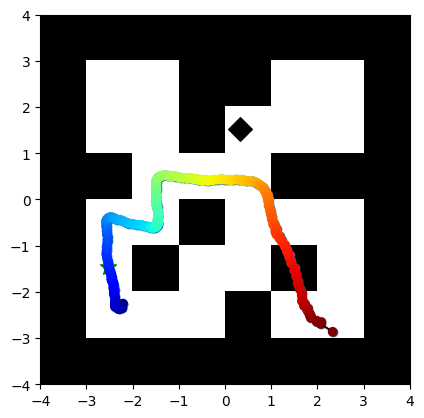

Saved 1 samples to: saved/sample-900000-4.png
Collision observations:


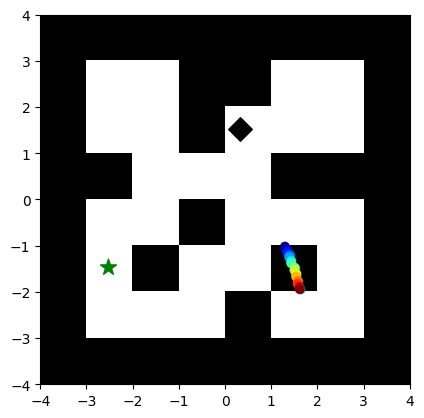

Saved 1 samples to: saved/sample-900000-4.png


In [19]:

corner_squares = [
    ((2, 3), (2, 3)),    
    ((-3, -2), (2, 3)),  
    ((2, 3), (-3, -2)),  
    ((-3, -2), (-3, -2)) 
]



def generate_random_points_from_corner_squares(batch_size=1):
    start_tensor = torch.zeros((batch_size, 2))
    end_tensor = torch.zeros((batch_size, 2))
    
    start_corner_indices = torch.randint(0, 4, (batch_size,))
    end_corner_indices = torch.randint(0, 4, (batch_size,))
    
    for i in range(batch_size):
        start_x_range, start_y_range = corner_squares[start_corner_indices[i]]
        end_x_range, end_y_range = corner_squares[end_corner_indices[i]]
        
        start_tensor[i, 0] = start_x_range[0] + (start_x_range[1] - start_x_range[0]) * torch.rand(1)
        start_tensor[i, 1] = start_y_range[0] + (start_y_range[1] - start_y_range[0]) * torch.rand(1)
        
        end_tensor[i, 0] = end_x_range[0] + (end_x_range[1] - end_x_range[0]) * torch.rand(1)
        end_tensor[i, 1] = end_y_range[0] + (end_y_range[1] - end_y_range[0]) * torch.rand(1)
    
    return start_tensor, end_tensor

for t in range(1): # For 5 different locations we pi ck      
    start_tensor, end_tensor = generate_random_points_from_corner_squares()

    
    trainer.render_samples_starting(
        env,
        get_cond_from_env=False,
        start_tensor=start_tensor,
        end_tensor=end_tensor,
        batch_size=5
    )